# Support Vector Machine

## Background

In this notebook, we will implement a linear support vector machine (SVM) model for classifying two-dimensional data.  For background, read [this Wikipedia article](https://en.wikipedia.org/wiki/Support_vector_machine).

## Notebook Setup

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxopt as cvx

# make cvxopt silent
cvx.solvers.options['show_progress'] = False

# set up notebook formatting
from IPython.core.display import display, HTML
display( HTML('<link rel="stylesheet" type="text/css" href="https://www.math.ksu.edu/~albin/smc_styles/smc_course.css">') )
None

## Well-separated data

When the data can be separated by a hyperplane, it is possible to formulate the [hard-margin problem](https://en.wikipedia.org/wiki/Support_vector_machine#Hard-margin): find the separating hyperplane that is equidistant from both categories.

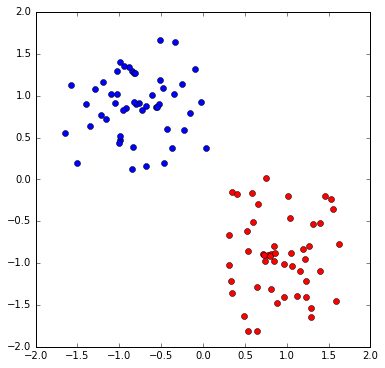

In [16]:
# number of data points
n = 100

# generate some random radii and angles
r = np.random.uniform(size=(n,))
t = np.random.uniform(size=(n,))*2*np.pi

# make a matrix whose rows are the 2D data points
x = np.zeros((n,2))
x[:,0] = r*np.cos(t)
x[:,1] = r*np.sin(t)

# split the points into two groups by translating
x[:n/2,0] -= 0.8
x[:n/2,1] += 0.9
x[n/2:,0] += 0.8
x[n/2:,1] -= 0.9

# set up the classification vector
y = np.ones(n)
y[n/2:] = -1

# now let's permute the entries so the data are mixed up
#ind = np.random.permutation(n)
#x = x[ind,:]
#y = y[ind]

# plot the data points
plt.figure(figsize=(6,6))
plt.plot( x[y<0,0], x[y<0,1], 'ro' )
plt.plot( x[y>0,0], x[y>0,1], 'bo' )
None

Here is a function implementing the hard-margin classifier using the QP formulation

\begin{align*}
    \text{minimize}\quad& \|w\|_2^2\\
    \text{subject to}\quad& y_i(x_i^Tw+b)\ge 1,\quad i=1,2,\ldots,n,
\end{align*}

where $\{x_i\}_{i=1}^n$ are the data points and $y_i\in\{-1,1\}$ are the associated classifications.

In [17]:
def classify_hard(x,y):
    ''' Finds a hard-margin linear classifier.
    
    Given an n-by-2 array of 2D points and a +/-1 classification vector y,
    this function finds a line of the form
    
      w^T x + b = 0
      
    that separates the two classes of points.  
    
    The function returns the tuple (w,b,z), where w and b define the
    separating hyperplane and z is the vector of dual variables for
    the inequality constraints.
    '''
    
    # count the number of points
    n = x.shape[0]

    # P matrix
    P = 2*cvx.spmatrix(1.0,[0,1],[0,1],(3,3))

    # q matrix
    q = cvx.matrix(0.,(3,1))

    #################################################
    # G matrix and h vector
    #
    # each sample point gives a constraint
    #
    G = np.zeros((n,3))
    h = -np.ones(n)

    # fill in rows assuming positive y (we'll fix signs later)
    G[:,:2] = x
    G[:,2]  = 1

    # now fix signs for positive y
    G[np.where(y>0),:] = -G[np.where(y>0),:]

    # convert to cvxopt matrices
    G = cvx.matrix(G)
    h = cvx.matrix(h)

    # solve the QP
    sln = cvx.solvers.qp(P,q,G,h)
    
    # check the status
    if sln['status'] != 'optimal':
        raise RuntimeError('QP solver failed to converge.')
        
    # convert to numpy 
    w = np.array(sln['x'][:2]).flatten()
    b = sln['x'][2]
    z = np.array(sln['z']).flatten()
    return w,b,z

In [18]:
w,b,z = classify_hard(x,y)
print 'w = ', w
print 'b = ', b

w =  [-1.65304668  2.82871884]
b =  -0.00147281174338


The following code plots the data along with the separating hyperplane $w^Tx+b=0$ (solid line) along with the lines $w^Tx+b=\pm 1$ (dashed lines).

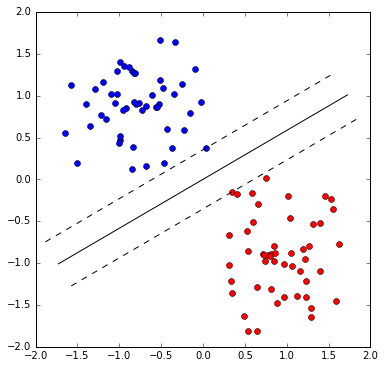

In [19]:
# find a point on the separating line
w2 = w.dot(w)
x0 = -b*w/(w2)

# the line points in the orthogonal direction to w
v = np.array( [w[1],-w[0]])
v /= np.linalg.norm(v)

# endpoints of the dividing line
l = np.array( [ [x0[0]+t*v[0],x0[1]+t*v[1]] for t in (-2,2)] )

plt.figure(figsize=(6,6))
plt.plot( x[y<0,0], x[y<0,1], 'ro' )
plt.plot( x[y>0,0], x[y>0,1], 'bo' )
plt.plot( l[:,0], l[:,1], 'k-')
plt.plot( l[:,0]+w[0]/w2, l[:,1]+w[1]/w2, 'k--')
plt.plot( l[:,0]-w[0]/w2, l[:,1]-w[1]/w2, 'k--')
None

The following cell shows the 10 largest dual variables $z$.  Notice that only very few of these values are significantly larger than 0.

</div>

In [21]:
np.sort(z)[-10:]

array([  3.54819411e-10,   4.88748496e-10,   1.08005183e-09,
         1.67280743e-09,   2.64294913e-09,   1.03062289e-08,
         2.75790654e-08,   3.50321766e-08,   1.07342135e+01,
         1.07342136e+01])

### The problem when data aren't well separated

If the data can't be separated by a hyperplane, something goes wrong.

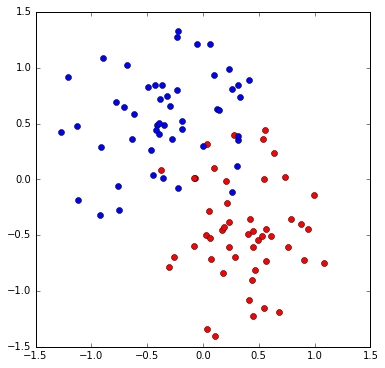

In [22]:
# number of data points
n = 100

# generate some random radii and angles
r = np.random.uniform(size=(n,))
t = np.random.uniform(size=(n,))*2*np.pi

# make a matrix whose rows are the 2D data points
x = np.zeros((n,2))
x[:,0] = r*np.cos(t)
x[:,1] = r*np.sin(t)

# split the points into two groups by translating
x[:n/2,0] -= 0.4
x[:n/2,1] += 0.5
x[n/2:,0] += 0.4
x[n/2:,1] -= 0.5

# set up the classification vector
y = np.ones(n)
y[n/2:] = -1

# now let's permute the entries so the data are mixed up
ind = np.random.permutation(n)
x = x[ind,:]
y = y[ind]

plt.figure(figsize=(6,6))
plt.plot( x[y<0,0], x[y<0,1], 'ro' )
plt.plot( x[y>0,0], x[y>0,1], 'bo' )
None

The data above show a clear trend: blue dots are, in general, above and to the left of red dots.  However, there is no clear separating plane.  Run the cell below to see what happens.

In [23]:
w,b = classify_hard(x,y)
print 'w = ', w
print 'b = ', b

Terminated (singular KKT matrix).


RuntimeError: QP solver failed to converge.

<div class="note assignment">
<h5>Question</h5> <p>What went wrong?  (Hint read the very last line of the error message.  What do you think it means?)</p>
<h5>Answer</h5> <p>[In this problem, the data sets are not linearly separabe, it is why Hard-Margin method is not able to solve it]</p>
</div>

## What to do when the data aren't separated

If the data aren't separated, then we should solve the [soft-margin problem](https://en.wikipedia.org/wiki/Support_vector_machine#Soft-margin). The primal QP formulation of the soft-margin problem can be found [here](https://en.wikipedia.org/wiki/Support_vector_machine#Computing_the_SVM_classifier).

<div class="note assignment">
<h5>Assignment</h5>
<p>Fill in the definition of the 'classify_soft' function below.  The behavior of the function is defined in the docstring.  After you've written the function, you can test it using the code below.  If you have written correct code, the data should be separated by reasonable looking lines that do not leave two many red or blue points on the wrong side.</p>
</div>

<div class="note hint">
<h5>Hints</h5>
<ul>
    <li>If you order your variables $(w_1,w_2,b,\zeta_1,\ldots,\zeta_n)$, you won't need to change the definition of 'P' much from the 'classify_hard' function.</li>
    <li>Part of 'G' can be constructed as in 'classify_hard'.</li>
    <li>Don't forget to include the $\zeta\succeq 0$ constraints.</li>
    <li>While developing your code, try using a smaller data set (6 points, say) so that you can inspect the entries in your arrays to ensure they make sense.</li>
</ul>
</div>

In [24]:
def classify_soft(x,y,lam):
    ''' Finds a soft-margin linear classifier.
    
    Given an n-by-2 array of 2D points, a +/-1 classification vector y,
    and a penalty parameter lam, this function finds a line of the form
    
      w^T x + b = 0
      
    that separates the two classes of points as well as possible in the
    soft-margin linear SVM sense.
    
    The function returns the tuple (w,b), where w is a numpy 2-vector and
    b is a scalar.
    '''
     
    # count the number of points
    n = x.shape[0]

    # P matrix
    P = lam*2*cvx.spmatrix(1.0,[0,1],[0,1],(n+3,n+3))

    # q matrix
    q=np.zeros(n+3)
    q[3:]=1
    q = (1./n)*cvx.matrix(q)

    #################################################
    # G matrix and h vector
    #
    # each sample point gives a constraint
    #
    G = np.zeros((2*n,n+3))
    
    h = np.zeros(2*n)

    # fill in rows assuming positive y (we'll fix signs later)
    G[:n,:2] = x
    G[:n,2]  = 1

    # now fix signs for positive y
    G[np.where(y>0),:] = -G[np.where(y>0),:]
    
    # add kesi constraints
    h[:n] = -np.ones(n)
    G[:n,3:]  = -np.eye(n)
    G[n:,3:] = -np.eye(n)
    

    # convert to cvxopt matrices
    G = cvx.matrix(G)
    h = cvx.matrix(h)

    # solve the QP
    sln = cvx.solvers.qp(P,q,G,h)
    
    # check the status
    if sln['status'] != 'optimal':
        raise RuntimeError('QP solver failed to converge.')
        
    # convert to numpy 
    w = np.array(sln['x'][:2]).flatten()
    b = sln['x'][2]
    kesi=np.array(sln['x'][3:]).flatten()
    z = np.array(sln['z']).flatten()
    return w,b,kesi,z
    
    
    
    raise NotImplementedError()

Here are some trials with different values of $\lambda$.

In [25]:
# trials with different values of lambda
lams = [ 1e3, 1, 1e-3]
res  = []

for lam in lams:
    w,b,kesi,z = classify_soft(x,y,lam)
    res.append((w,b))
    print 'lam = ', lam
    print 'w  = ', w
    print 'b  = ', b
    print

lam =  1000.0
w  =  [-0.00017274  0.00025225]
b  =  -9.17921678095e-06

lam =  1
w  =  [-0.17273534  0.25224984]
b  =  -0.0137848030865

lam =  0.001
w  =  [-2.46740764  2.44973191]
b  =  -0.169359234067



And here are the associated plots.

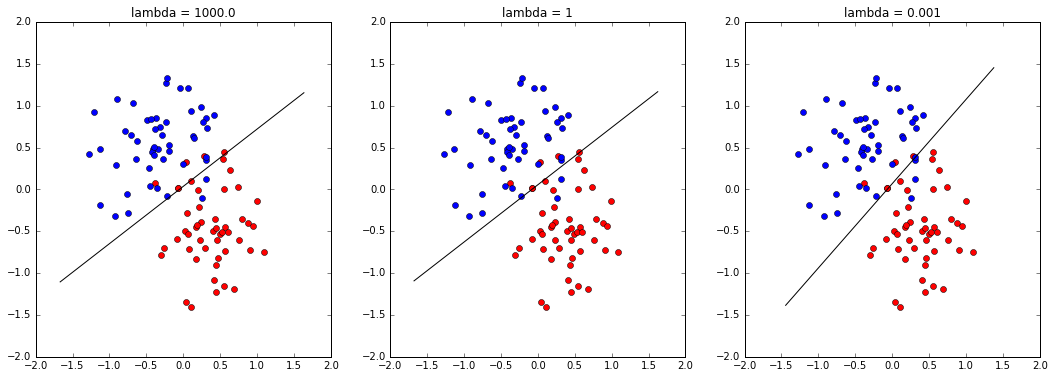

In [26]:
plt.figure(figsize=(18,6))

for e,(w,b) in enumerate(res):
    
    # find a point on the separating line
    w2 = w.dot(w)
    x0 = -b*w/(w2)

    # the line points in the orthogonal direction to w
    v = np.array( [w[1],-w[0]])
    v /= np.linalg.norm(v)
    
    # endpoints of the dividing line
    l = np.array( [ [x0[0]+t*v[0],x0[1]+t*v[1]] for t in (-2,2)] )

    plt.subplot(1,3,e+1)
    plt.plot( x[y<0,0], x[y<0,1], 'ro' )
    plt.plot( x[y>0,0], x[y>0,1], 'bo' )
    plt.plot( l[:,0], l[:,1], 'k-')
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.title('lambda = {}'.format(lams[e]))